In [6]:
import torch
import matplotlib.pyplot as plt
from ipywidgets import AppLayout, GridspecLayout, IntSlider, FloatSlider, Button, Layout, HBox, VBox
import math


from torch.nn.functional import softmax, log_softmax
%matplotlib widget

In [7]:
def create_slider(name, range, start, update_fn, smooth=True, N=50):
    SliderClass = FloatSlider if smooth else IntSlider
    slider = SliderClass( description=name,
                layout=Layout(height='auto', width='auto'),
                orientation='horizontal',
                min=range[0],
                max=range[1],
                step=(range[1]-range[0]) / N,
                value=start)
    slider.observe(update_fn, names='value')
    return slider

### Common losses in self-supervised learning

In [8]:
def dotsim(x_star:torch.Tensor, x:torch.Tensor):
    return (x_star * x).sum(dim=-1)

def cossim(x_star:torch.Tensor, x:torch.Tensor):
    return dotsim(x_star, x) / (x_star.norm(dim=-1) * x.norm(dim=-1) + 1e-4)

def mse(x_star:torch.Tensor, x:torch.Tensor): # acutally sum of squred errors
    return (x_star - x).square().sum(dim=-1)
    return dotsim(x_star - x, x_star - x)
    return -2*dotsim(x_star, x) + x_star.norm().square() + x.norm().square()

def l2(x_star:torch.Tensor, x:torch.Tensor):
    return mse(x_star, x).sqrt()

def ce(x_star:torch.Tensor, x:torch.Tensor):
    targ = softmax(x_star, dim=-1)
    log_pred = log_softmax(x, dim=-1)
    return torch.sum(targ * -log_pred, dim=-1)

def kl(x_star:torch.Tensor, x:torch.Tensor):
    targ = softmax(x_star, dim=-1)
    log_targ = log_softmax(x_star, dim=-1)
    log_pred = log_softmax(x, dim=-1)
    return torch.sum(targ * -(log_pred - log_targ), dim=-1)

def entropy(x:torch.Tensor):
    prob = softmax(x, dim=-1)
    log_prob = log_softmax(x, dim=-1)
    return torch.sum(prob * -log_prob, dim=-1)


In [9]:
def plot_loss(loss, x_star=torch.Tensor([1,1]), lim=(0,2), N=100, cN=50, clim=(None, None), ax=None):
    if ax is None:
        ax = plt.figure().gca()
    
    x = torch.linspace(lim[0], lim[1], N)
    y = torch.linspace(lim[0], lim[1], N)
    M = torch.stack(torch.meshgrid(x, y, indexing='ij'), dim=-1)
    z = loss(x_star, M)

    p = ax.contourf(M[:,:,0], M[:,:,1], z, levels=cN, vmin=clim[0], vmax=clim[1], cmap='jet')
    ax.arrow(0, 0, x_star[0], x_star[1], length_includes_head=True, width=0.01, head_width=0.2, color='k')
    ax.set_aspect('equal', 'box')
    ax.set_title(loss.__name__)
    plt.colorbar(p, ax=ax)
    return ax

<AxesSubplot:title={'center':'kl'}>

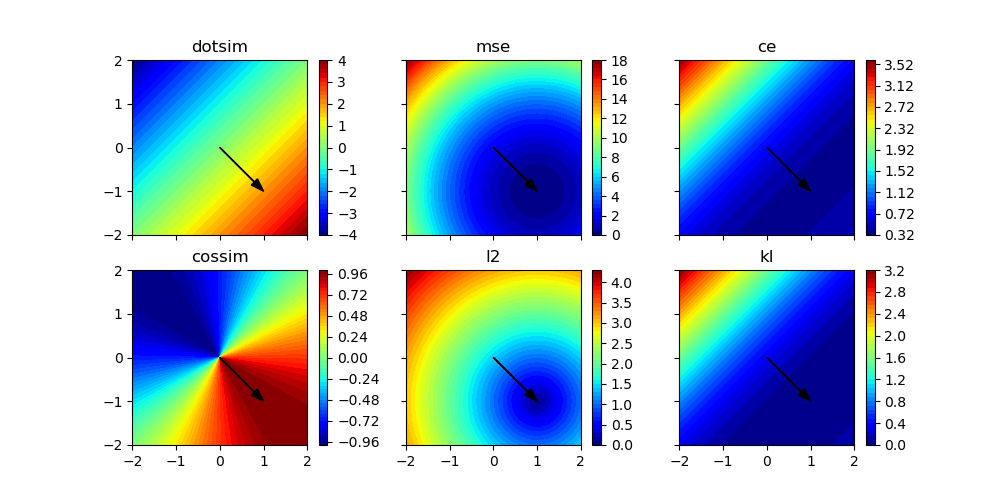

In [10]:
lim = (-2, 2)
x_star = torch.Tensor([1,-1])
_, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 5))
plot_loss(dotsim, x_star, lim, ax=ax[0][0])
plot_loss(cossim, x_star, lim, ax=ax[1][0])
plot_loss(mse, x_star, lim, ax=ax[0][1])
plot_loss(l2,  x_star, lim, ax=ax[1][1])
plot_loss(ce,  x_star, lim, ax=ax[0][2])
plot_loss(kl,  x_star, lim, ax=ax[1][2])


### The cross entropy grows in O(n) like the l2 distance

<AxesSubplot:>

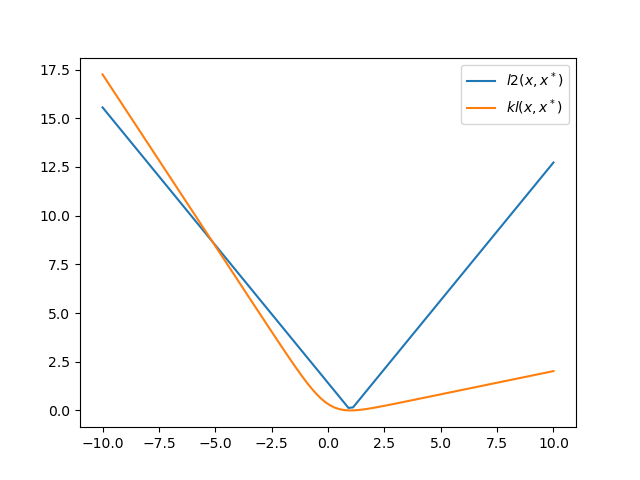

In [11]:
def plot_growth(lim=(-10, 10), N=100, ax=None):
    if ax is None:
        ax = plt.figure().gca()

    t = torch.linspace(lim[0], lim[1], N).unsqueeze(1)
    X = t * torch.Tensor([-1, 1]).repeat(100,1)

    x_star = torch.Tensor([-1,1])
    #ax.plot(t, mse(x_star, X), label='$mse(x, x^*)$')
    ax.plot(t, l2(x_star, X), label='$l2(x, x^*)$')
    ax.plot(t, kl(x_star, X), label='$kl(x, x^*)$')
    ax.legend()
    return ax

plot_growth(lim=(-10, 10))

### Entropy in logits space

In [12]:
def plot_entropy_logits(lim=(-2,2), N=100, cN=50, clim=(None, None), ax=None):
    if ax is None:
        ax = plt.figure().gca()
    
    x = torch.linspace(lim[0], lim[1], N)
    y = torch.linspace(lim[0], lim[1], N)
    M = torch.stack(torch.meshgrid(x, y, indexing='ij'), dim=-1)
    H = entropy(M)

    p = ax.contourf(M[:,:,0], M[:,:,1], H, levels=cN, vmin=clim[0], vmax=clim[1], cmap='jet')
    ax.set_aspect('equal', 'box')
    ax.set_title('Entropy of Logits')
    plt.colorbar(p, ax=ax)
    return ax

In [13]:
def plot_entropy_probas(N=100, ax=None):
    if ax is None:
        ax = plt.figure().gca()
    
    prob = torch.linspace(0, 1, N)
    prob = torch.stack((prob, 1-prob), dim=-1)

    H = torch.sum(prob * -torch.log(prob), dim=-1)
    ax.plot(prob, H)
    ax.set_title('Entropy of Probabilities')

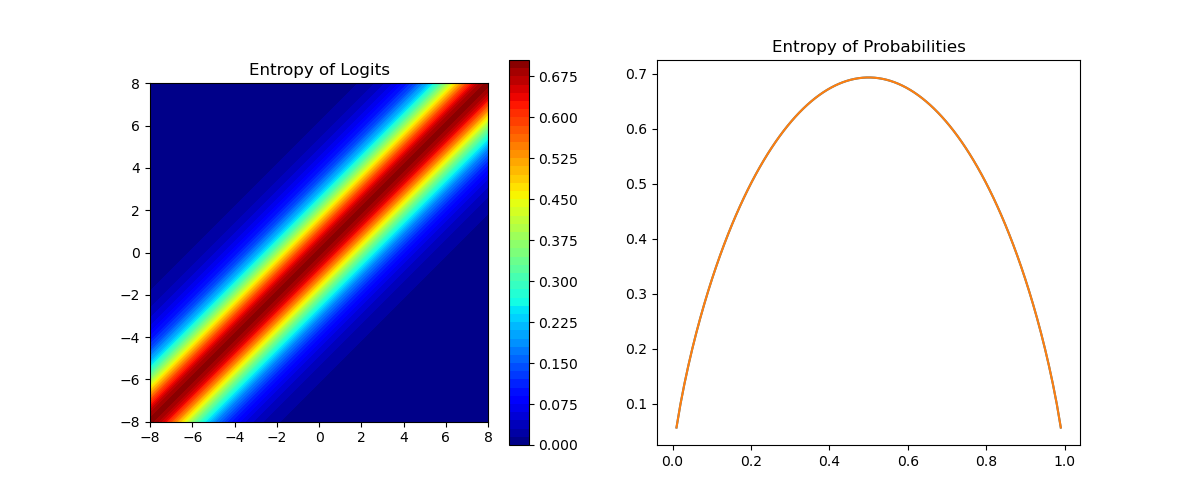

In [14]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 5))
plot_entropy_logits(lim=(-8,8), ax=ax[0])
plot_entropy_probas(ax=ax[1])


### The effect of sharpening on entropy

In [15]:
def plot_sharpening(t_min=0.2, lim=(-10, 10), N=100):
    plt.ioff()
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 5))
    plot_entropy_logits(lim=lim, N=N, cN=N//2, ax=ax[0])

    # data
    state=dict(r=1, phi=-.25*math.pi)
    r, phi = state['r'], state['phi']
    x = torch.Tensor([r*math.cos(phi), r*math.sin(phi)])
    t = 1/torch.linspace(1, 1/t_min, N)
    xs = x.unsqueeze(0)/t.unsqueeze(1)

    # plot
    arr1 = ax[0].arrow(0, 0, x[0], x[1], length_includes_head=True, width=0.01, head_width=0.2, color='k')
    arr2 = ax[0].arrow(0, 0, x[0]/t_min, x[1]/t_min)
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)

    line, = ax[1].plot(t, entropy(xs))
    ax[1].set_ylim((0, math.log(2)))
    ax[1].invert_xaxis()
    ax[1].set_title('Entropy vs Temperature')

    def update(state):        
        r, phi = state['r'], state['phi']
        x = torch.Tensor([r*math.cos(phi), r*math.sin(phi)])
        xs = x.unsqueeze(0)/t.unsqueeze(1)

        arr1.set_data(x=0, y=0, dx=x[0], dy=x[1])
        arr2.set_data(x=0, y=0, dx=x[0]/t_min, dy=x[1]/t_min)
        line.set_ydata(entropy(xs))

        fig.canvas.draw()
        fig.canvas.flush_events()
    
    def update_r(change):
        state['r'] = change.new
        update(state)

    def update_phi(change):
        state['phi'] = change.new
        update(state)

    sliders = VBox([
        create_slider('r', range=(0, lim[1]), start=state['r'], update_fn=update_r),
        create_slider('phi', range=(-1.25*math.pi, .75*math.pi), start=state['phi'], update_fn=update_phi)],
        layout=Layout(width='40%', height='auto', margin = '0px 30% 0px 30%')
    )

    widget = AppLayout(
        center=fig.canvas,
        footer=sliders,
        pane_heights=[0, 6, 1]
    )
    plt.ion()
    return widget

plot_sharpening(t_min=0.1, lim=(-10, 10))

AppLayout(children=(VBox(children=(FloatSlider(value=1.0, description='r', layout=Layout(height='auto', width=…

In [16]:
#ax = plt.figure().gca()
#
#n_classes = 2048
#lim = (0, 4)
#
#x = torch.randn(n_classes).unsqueeze(0)
#t = 10**-torch.linspace(lim[0], lim[1], n_classes).unsqueeze(1)
#
#H = -torch.sum(softmax(x/t, dim=-1)*log_softmax(x/t, dim=-1), dim=-1)
#
#ax.plot(t, H)
#ax.invert_xaxis()
#ax.set_xscale('log')

### Effect of centering and sharpening on crossentropy / kl divergence

In [17]:
def plot_kl_logits(lim=(-2, 2), N = 100, cN = 50):
    # Widget should handly interactive 
    plt.ioff()
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(8, 4))

    # Data
    state=dict(r=1, phi=-.5, t_stud=1)
    r, phi, t_stud = state['r'], (state['phi'] + 0.25)*math.pi, state['t_stud']
    x = torch.Tensor([r*math.cos(phi), r*math.sin(phi)])
    M = torch.stack(torch.meshgrid([
            torch.linspace(lim[0], lim[1], N),
            torch.linspace(lim[0], lim[1], N)],
            indexing='ij'), dim=-1)
    KL = kl(x, M)

    # Default axis
    vmin, vmax = KL.min(), KL.max()
    cont = ax.contourf(M[:,:,0]/t_stud, M[:,:,1]/t_stud, KL, levels=cN, cmap='jet', vmin=vmin, vmax=vmax)
    arr1 = ax.arrow(0, 0, x[0], x[1], length_includes_head=True, width=0.01, head_width=0.2, color='k', zorder=10)


    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal', 'box')

    plt.colorbar(cont, ax=ax)
    plt.suptitle('KL-Divergence of Logits')


    def update(state):
        r, phi, t_stud = state['r'], (state['phi'] + 0.25)*math.pi, state['t_stud']
        x = torch.Tensor([r*math.cos(phi), r*math.sin(phi)])
        KL_new = kl(x, M)

        #for c in cont.collections:
        #    ax.collections.remove(c)
        #    cont.collections.remove(c)  # removes only the contours, leaves the rest intact
        cont = ax.contourf(M[:,:,0]/t_stud, M[:,:,1]/t_stud, KL_new, levels=cN, cmap='jet', vmin=vmin, vmax=vmax)
        arr1.set_data(x=0, y=0, dx=x[0], dy=x[1])

        fig.canvas.draw()
        fig.canvas.flush_events()

    def update_r(change):
        state['r'] = change.new
        update(state)

    def update_phi(change):
        state['phi'] = change.new
        update(state)

    def update_t_stud(change):
        state['t_stud'] = change.new
        update(state)

    sliders = VBox([
        create_slider('r', range=(0, lim[1]), start=state['r'], update_fn=update_r),
        create_slider('phi', range=(-1, 1), start=state['phi'], update_fn=update_phi),
        create_slider('t_stud', range=(0.1, 1), start=state['t_stud'], update_fn=update_t_stud)],
        layout=Layout(width='40%', height='auto', margin = '0px 20% 0px 20%')
    )

    widget = AppLayout(
        center=fig.canvas,
        footer=sliders,
        pane_heights=[0, 8, 2]
        )

    plt.ion()
    return widget

plot_kl_logits(lim=(-2,2))

AppLayout(children=(VBox(children=(FloatSlider(value=1.0, description='r', layout=Layout(height='auto', width=…

### Entropy in 3D

In [30]:
import cv2
import numpy as np
R,_ = cv2.Rodrigues(np.pi * np.array([0.25, 0.25, 0.25]))

(3, 3)

torch.Size([100, 100, 3])


<AxesSubplot:title={'center':'Entropy of Logits 3D'}>

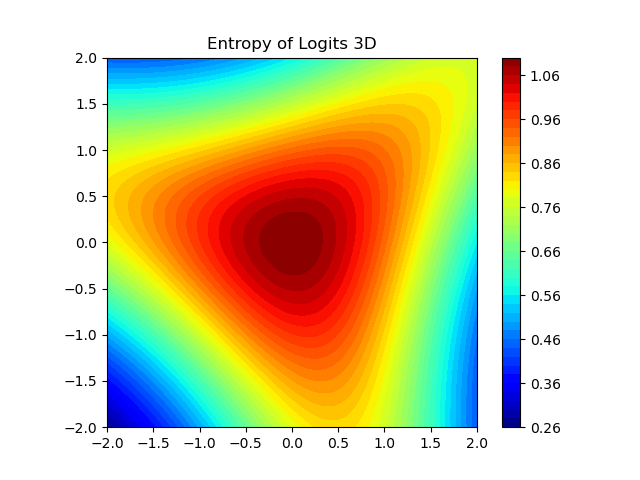

In [58]:
def plot_entropy_logits_3d(lim=(-2,2), N=100, cN=50, clim=(None, None), ax=None):
    if ax is None:
        ax = plt.figure().gca()
    
    x = torch.linspace(lim[0], lim[1], N)
    y = torch.linspace(lim[0], lim[1], N)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    Z = torch.zeros_like(X)
    M = torch.stack((X, Y, Z), dim=-1)

    v_from, v_to = torch.Tensor([0,0,1]), torch.Tensor([1, 1, 1]) / math.sqrt(3)
    R = torch.from_numpy(cv2.Rodrigues(torch.cross(v_from, v_to).numpy())[0])
    H = entropy(M @ R.T)

    p = ax.contourf(M[:,:,0], M[:,:,1], H, levels=cN, vmin=clim[0], vmax=clim[1], cmap='jet')
    ax.set_aspect('equal', 'box')
    ax.set_title('Entropy of Logits 3D')
    plt.colorbar(p, ax=ax)
    return ax
plot_entropy_logits_3d()

In [63]:
def plot_sharpening_3d(t_min=0.2, lim=(-10, 10), N=100):
    plt.ioff()
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 5))
    plot_entropy_logits_3d(lim=lim, N=N, cN=N//2, ax=ax[0])

    v_from, v_to = torch.Tensor([0,0,1]), torch.Tensor([1, 1, 1]) / math.sqrt(3)
    R = torch.from_numpy(cv2.Rodrigues(torch.cross(v_from, v_to).numpy())[0])

    # data
    state=dict(r=1, phi=-.25*math.pi)
    r, phi = state['r'], state['phi']
    x = R @ torch.Tensor([r*math.cos(phi), r*math.sin(phi), 0])
    t = 1/torch.linspace(1, 1/t_min, N)
    xs = x.unsqueeze(0)/t.unsqueeze(1)

    
    
    # plot
    arr1 = ax[0].arrow(0, 0, x[0], x[1], length_includes_head=True, width=0.01, head_width=0.2, color='k')
    arr2 = ax[0].arrow(0, 0, x[0]/t_min, x[1]/t_min)
    ax[0].set_xlim(lim)
    ax[0].set_ylim(lim)

    line, = ax[1].plot(t, entropy(xs))
    ax[1].set_ylim((0, math.log(3)))
    ax[1].invert_xaxis()
    ax[1].set_title('Entropy vs Temperature')

    def update(state):        
        r, phi = state['r'], state['phi']
        x = R @ torch.Tensor([r*math.cos(phi), r*math.sin(phi), 0])
        xs = x.unsqueeze(0)/t.unsqueeze(1)

        arr1.set_data(x=0, y=0, dx=x[0], dy=x[1])
        arr2.set_data(x=0, y=0, dx=x[0]/t_min, dy=x[1]/t_min)
        line.set_ydata(entropy(xs))

        fig.canvas.draw()
        fig.canvas.flush_events()
    
    def update_r(change):
        state['r'] = change.new
        update(state)

    def update_phi(change):
        state['phi'] = change.new
        update(state)

    sliders = VBox([
        create_slider('r', range=(0, lim[1]), start=state['r'], update_fn=update_r),
        create_slider('phi', range=(-1.25*math.pi, .75*math.pi), start=state['phi'], update_fn=update_phi)],
        layout=Layout(width='40%', height='auto', margin = '0px 30% 0px 30%')
    )

    widget = AppLayout(
        center=fig.canvas,
        footer=sliders,
        pane_heights=[0, 6, 1]
    )
    plt.ion()
    return widget

plot_sharpening_3d(t_min=0.1, lim=(-10, 10))

torch.Size([100, 100, 3])


AppLayout(children=(VBox(children=(FloatSlider(value=1.0, description='r', layout=Layout(height='auto', width=…

In [66]:
def plot_kl_logits_3d(lim=(-2, 2), N = 100, cN = 50):
    # Widget should handly interactive 
    plt.ioff()
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(8, 4))

    v_from, v_to = torch.Tensor([0,0,1]), torch.Tensor([1, 1, 1]) / math.sqrt(3)
    R = torch.from_numpy(cv2.Rodrigues(torch.cross(v_from, v_to).numpy())[0])

    # Data
    state=dict(r=1, phi=-.5, t_stud=1)
    r, phi, t_stud = state['r'], (state['phi'] + 0.25)*math.pi, state['t_stud']
    x = torch.Tensor([r*math.cos(phi), r*math.sin(phi), 0])

    X, Y =torch.meshgrid([
            torch.linspace(lim[0], lim[1], N),
            torch.linspace(lim[0], lim[1], N)],
            indexing='ij')
    Z = torch.zeros_like(X)
    M = torch.stack((X, Y, Z), dim=-1)

    KL = kl(R @ x, M @ R.T)

    # Default axis
    vmin, vmax = KL.min(), KL.max()
    cont = ax.contourf(M[:,:,0]/t_stud, M[:,:,1]/t_stud, KL, levels=cN, cmap='jet', vmin=vmin, vmax=vmax)
    arr1 = ax.arrow(0, 0, x[0], x[1], length_includes_head=True, width=0.01, head_width=0.2, color='k', zorder=10)


    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal', 'box')

    plt.colorbar(cont, ax=ax)
    plt.suptitle('KL-Divergence of Logits')


    def update(state):
        r, phi, t_stud = state['r'], (state['phi'] + 0.25)*math.pi, state['t_stud']
        x = torch.Tensor([r*math.cos(phi), r*math.sin(phi), 0])
        KL_new = kl(R @ x, M @ R.T)

        #for c in cont.collections:
        #    ax.collections.remove(c)
        #    cont.collections.remove(c)  # removes only the contours, leaves the rest intact
        cont = ax.contourf(M[:,:,0]/t_stud, M[:,:,1]/t_stud, KL_new, levels=cN, cmap='jet', vmin=vmin, vmax=vmax)
        arr1.set_data(x=0, y=0, dx=x[0], dy=x[1])

        fig.canvas.draw()
        fig.canvas.flush_events()

    def update_r(change):
        state['r'] = change.new
        update(state)

    def update_phi(change):
        state['phi'] = change.new
        update(state)

    def update_t_stud(change):
        state['t_stud'] = change.new
        update(state)

    sliders = VBox([
        create_slider('r', range=(0, lim[1]), start=state['r'], update_fn=update_r),
        create_slider('phi', range=(-1, 1), start=state['phi'], update_fn=update_phi),
        create_slider('t_stud', range=(0.1, 1), start=state['t_stud'], update_fn=update_t_stud)],
        layout=Layout(width='40%', height='auto', margin = '0px 20% 0px 20%')
    )

    widget = AppLayout(
        center=fig.canvas,
        footer=sliders,
        pane_heights=[0, 8, 2]
        )

    plt.ion()
    return widget

plot_kl_logits_3d(lim=(-10,10))

AppLayout(children=(VBox(children=(FloatSlider(value=1.0, description='r', layout=Layout(height='auto', width=…